In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
#import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect(r"C:\Users\Ram Nikhilesh\Desktop\ai class\csv files\test data\database.sqlite")
filtered_data=pd.read_sql_query("""select * from Reviews where Score !=3""",con)

def partition(x):
    if x < 3:
        return 0
    return 1

actualscore=filtered_data['Score']
positiveneagtive=actualscore.map(partition)
filtered_data["Score"]=positiveneagtive

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned





if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] 
    all_negative_words=[] 
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        
        sent=cleanhtml(sent) 
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) 
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s)  
                    else:
                        continue
                else:
                    continue 
        
        str1 = b" ".join(filtered_sentence) 
       

        final_string.append(str1)
        i+=1
    final['CleanedText']=final_string 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()




In [3]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [4]:
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



The optimal number of neighbors is 1.


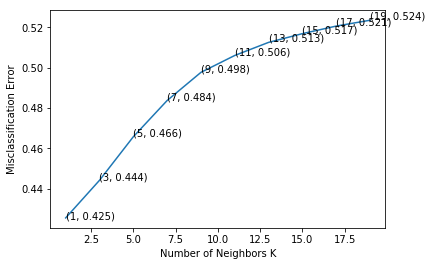

the misclassification error for each k value is :  [0.425 0.444 0.466 0.484 0.498 0.506 0.513 0.517 0.521 0.524]


In [5]:
final_=final['CleanedText']
final_1000=final_[0:60000]
score_=final['Score']
score_1000=score_[0:60000]


tscv = TimeSeriesSplit(n_splits=2,max_train_size=42000)
#TimeSeriesSplit(max_train_size=70, n_splits=3)
for train,test in tscv.split(final_1000):
    
    X_train, X_test = final_1000[train], final_1000[test]
    y_train, y_test = score_1000[train], score_1000[test]



    
tscv1 = TimeSeriesSplit(n_splits=2,max_train_size=12600) 


for final_train,cv in tscv1.split(X_train):
    X_train1, X_cv = X_train[train], X_train[cv]
    y_train1, y_cv = y_train[train], y_train[cv]
    #print(X_train1)
    #print(y_train1)


count_vector=CountVectorizer(min_df=10)
    
train_counts=count_vector.fit_transform(X_train1)
cv_counts=count_vector.transform(X_cv)
test_counts=count_vector.transform(X_test)

myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores=[]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_counts,y_train1)
    scores = cross_val_score(knn, train_counts, y_train1, cv=4, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
    
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

    




Test accuracy for k 1 is 79%

Test accuracy for k 1 is 79%


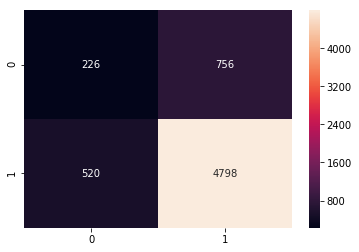

In [7]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(train_counts,y_train1)
predicted_labels=[]
test_labels=[]
for k in range(1,12600,6300):
    test_labels=(y_test[k:k+6300]) 
    predicted_labels=(knn.predict(test_counts[k:k+6300]))
    #pred = knn.predict(test_counts)
    acc = accuracy_score(test_labels, predicted_labels, normalize=True) * float(100)
    print('\nTest accuracy for k %d is %d%%' % (optimal_k,acc))
    
    
sample=confusion_matrix(test_labels,predicted_labels)
ax=sns.heatmap(sample,annot=True,fmt="d")    


The optimal number of neighbors is 1.


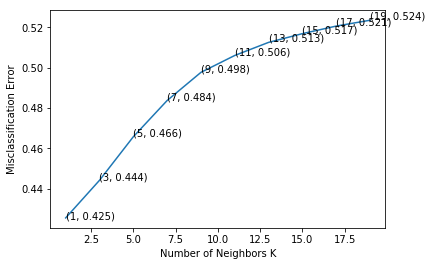

the misclassification error for each k value is :  [0.425 0.444 0.466 0.484 0.498 0.506 0.513 0.517 0.521 0.524]


In [10]:
import warnings
warnings.filterwarnings('ignore')
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores=[]
#train_counts.todense()
#train_counts.toarray()
svd = TruncatedSVD(algorithm='randomized',n_components=2, n_iter=2)
svd.fit(train_counts)
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(train_counts,y_train1)
    #pred_cv=knn.predict(cv_counts)
    #acc = accuracy_score(y_cv,pred_cv,normalize=True) * float (100)
    #print('\ nCV accuracy for k = %d is %d%%' % (i, acc)) 
    scores = cross_val_score(knn, train_counts, y_train1, cv=4, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
    
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

    



Test accuracy for k  1 is 79%

Test accuracy for k  1 is 79%


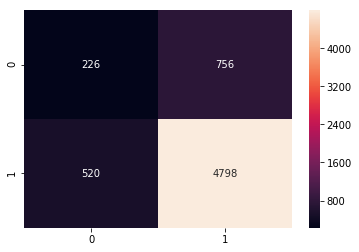

In [11]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(train_counts,y_train1)
predicted_labels=[]
test_labels=[]
for k in range(1,12600,6300):
    test_labels=(y_test[k:k+6300]) 
    predicted_labels=(knn.predict(test_counts[k:k+6300]))
    #pred = knn.predict(test_counts)
    acc = accuracy_score(test_labels, predicted_labels, normalize=True) * float(100)
    print('\nTest accuracy for k  %d is %d%%' % (optimal_k,acc))
    
sample=confusion_matrix(test_labels,predicted_labels)
ax=sns.heatmap(sample,annot=True,fmt="d")     
    


The optimal number of neighbors is 3.


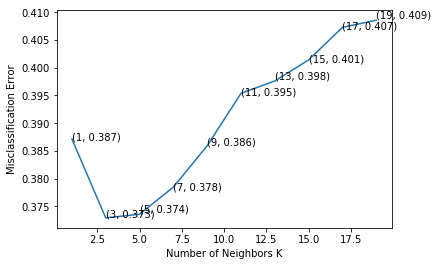

the misclassification error for each k value is :  [0.387 0.373 0.374 0.378 0.386 0.395 0.398 0.401 0.407 0.409]


In [12]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
train_vect = tf_idf_vect.fit_transform(X_train1)
cv_vect=tf_idf_vect.transform(X_cv)
test_vect = tf_idf_vect.transform(X_test)


myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores=[]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_vect,y_train1)
    #pred_cv=knn.predict(cv_counts)
    #acc = accuracy_score(y_cv,pred_cv,normalize=True) * float (100)
    #print('\ nCV accuracy for k = %d is %d%%' % (i, acc)) 
    scores = cross_val_score(knn, train_vect, y_train1, cv=4, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
    
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))





Test accuracy for k 3 is 83%

Test accuracy for k 3 is 83%


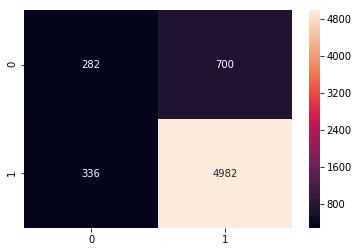

In [13]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(train_vect,y_train1)
predicted_labels=[]
test_labels=[]
for k in range(1,12600,6300):
    test_labels=(y_test[k:k+6300]) 
    predicted_labels=(knn.predict(test_vect[k:k+6300]))
    #pred = knn.predict(test_vect)
    acc = accuracy_score(test_labels, predicted_labels, normalize=True) * float(100)
    print('\nTest accuracy for k %d is %d%%' % (optimal_k,acc))
    
sample=confusion_matrix(test_labels,predicted_labels)
ax=sns.heatmap(sample,annot=True,fmt="d")    


The optimal number of neighbors is 3.


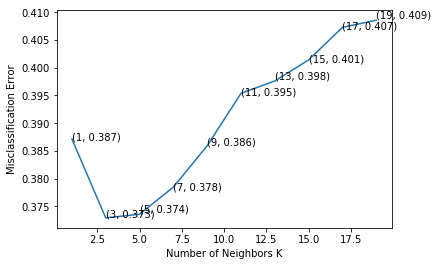

the misclassification error for each k value is :  [0.387 0.373 0.374 0.378 0.386 0.395 0.398 0.401 0.407 0.409]


In [14]:
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores=[]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(train_vect,y_train1)
    #pred_cv=knn.predict(cv_counts)
    #acc = accuracy_score(y_cv,pred_cv,normalize=True) * float (100)
    #print('\ nCV accuracy for k = %d is %d%%' % (i, acc)) 
    scores = cross_val_score(knn, train_vect, y_train1, cv=4, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
    
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))



Test accuracy for k 3 is 83%

Test accuracy for k 3 is 83%


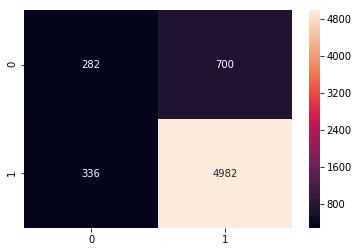

In [15]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(train_vect,y_train1)
predicted_labels=[]
test_labels=[]
for k in range(1,12600,6300):
    test_labels=(y_test[k:k+6300]) 
    predicted_labels=(knn.predict(test_vect[k:k+6300]))
    #pred = knn.predict(test_vect)
    acc = accuracy_score(test_labels, predicted_labels, normalize=True) * float(100)
    print('\nTest accuracy for k %d is %d%%' % (optimal_k,acc))
    
sample=confusion_matrix(test_labels,predicted_labels)
ax=sns.heatmap(sample,annot=True,fmt="d")    

In [6]:
i=0
list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())

In [7]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [14]:
sent_vectors = []; 
for sent in tqdm(X_train1): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [2:25:24<00:00, 10.27it/s]



The optimal number of neighbors is 7.


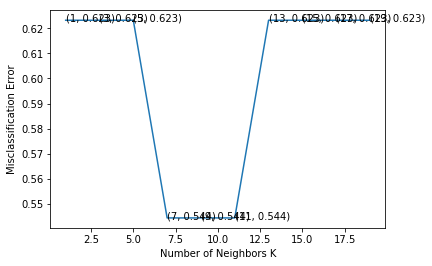

the misclassification error for each k value is :  [0.623 0.623 0.623 0.544 0.544 0.544 0.623 0.623 0.623 0.623]


In [19]:
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores=[]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(sent_vectors,y_train1)
    #pred_cv=knn.predict(cv_counts)
    #acc = accuracy_score(y_cv,pred_cv,normalize=True) * float (100)
    #print('\ nCV accuracy for k = %d is %d%%' % (i, acc)) 
    scores = cross_val_score(knn, sent_vectors, y_train1, cv=4, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
    
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [51:41<00:00,  9.90it/s]



Test accuracy for k 9 is 83%


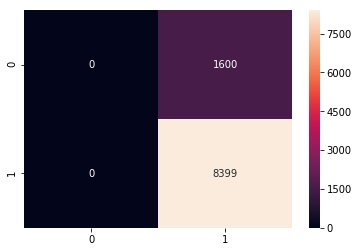

In [17]:
test_vectors = []; 
for sent in tqdm(X_test): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)




knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(sent_vectors,y_train1)
predicted_labels=[]
test_labels=[]
for k in range(1,20000,10000):
    test_labels=(y_test[k:k+10000]) 
    predicted_labels=(knn.predict(test_vectors[k:k+10000]))
pred = knn.predict(test_vectors)
acc = accuracy_score(test_labels, predicted_labels, normalize=True) * float(100)
print('\nTest accuracy for k %d is %d%%' % (optimal_k,acc))


sample=confusion_matrix(test_labels,predicted_labels)
ax=sns.heatmap(sample,annot=True,fmt="d")

C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaco

C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaco


The optimal number of neighbors is 9.


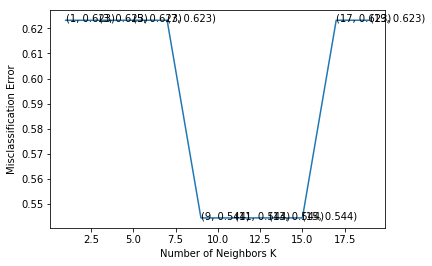

the misclassification error for each k value is :  [0.623 0.623 0.623 0.623 0.544 0.544 0.544 0.544 0.623 0.623]


In [15]:
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores=[]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(sent_vectors,y_train1)
    #pred_cv=knn.predict(cv_counts)
    #acc = accuracy_score(y_cv,pred_cv,normalize=True) * float (100)
    #print('\ nCV accuracy for k = %d is %d%%' % (i, acc)) 
    scores = cross_val_score(knn, sent_vectors, y_train1, cv=4, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
    
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))



Test accuracy for k 9 is 82%

Test accuracy for k 9 is 84%


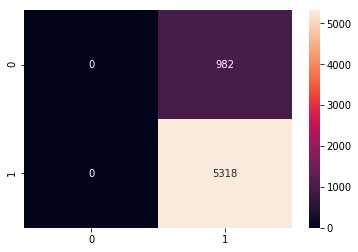

In [18]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(sent_vectors,y_train1)
predicted_labels=[]
test_labels=[]
for k in range(1,12600,6300):
    test_labels=(y_test[k:k+6300]) 
    predicted_labels=(knn.predict(test_vectors[k:k+6300]))
#pred = knn.predict(test_vectors)
    acc = accuracy_score(test_labels, predicted_labels, normalize=True) * float(100)
    print('\nTest accuracy for k %d is %d%%' % (optimal_k,acc))
    
sample=confusion_matrix(test_labels,predicted_labels)
ax=sns.heatmap(sample,annot=True,fmt="d")



In [9]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_sent_vectors = [];
row=0;
for sent in tqdm(X_train1):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [1:08:39<00:00,  9.71it/s]


C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaco

C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaco


The optimal number of neighbors is 7.


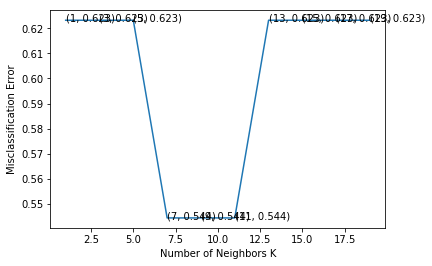

the misclassification error for each k value is :  [0.623 0.623 0.623 0.544 0.544 0.544 0.623 0.623 0.623 0.623]


In [10]:
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores=[]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(tfidf_sent_vectors,y_train)
    #pred_cv=knn.predict(cv_counts)
    #acc = accuracy_score(y_cv,pred_cv,normalize=True) * float (100)
    #print('\ nCV accuracy for k = %d is %d%%' % (i, acc)) 
    scores = cross_val_score(knn, tfidf_sent_vectors, y_train1, cv=4, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
    
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [43:04<00:00, 12.16it/s]



Test accuracy for k 7 is 82%

Test accuracy for k 7 is 84%


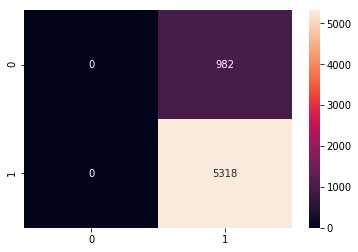

In [11]:
#model = TfidfVectorizer()
#tf_idf_matrix = model.fit_transform(X_test)
#dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(X_test):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
    
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(tfidf_sent_vectors,y_train1)
predicted_labels=[]
test_labels=[]
for k in range(1,12600,6300):
    test_labels=(y_test[k:k+6300]) 
    predicted_labels=(knn.predict(tfidf_sent_vectors_test[k:k+6300]))
    #pred = knn.predict(tfidf_sent_vectors_test)
    acc = accuracy_score(test_labels, predicted_labels, normalize=True) * float(100)
    print('\nTest accuracy for k %d is %d%%' % (optimal_k,acc))    
    
    
sample=confusion_matrix(test_labels,predicted_labels)
ax=sns.heatmap(sample,annot=True,fmt="d")    

C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaco

C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ram Nikhilesh\Anaco


The optimal number of neighbors is 9.


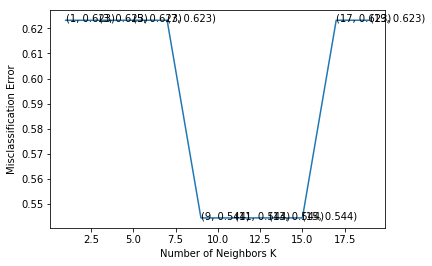

the misclassification error for each k value is :  [0.623 0.623 0.623 0.623 0.544 0.544 0.544 0.544 0.623 0.623]


In [12]:
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores=[]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(tfidf_sent_vectors,y_train)
    #pred_cv=knn.predict(cv_counts)
    #acc = accuracy_score(y_cv,pred_cv,normalize=True) * float (100)
    #print('\ nCV accuracy for k = %d is %d%%' % (i, acc)) 
    scores = cross_val_score(knn, tfidf_sent_vectors, y_train1, cv=4, scoring='f1_macro')
    cv_scores.append(scores.mean())
    
    
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:33:42<00:00,  3.56it/s]



Test accuracy for k 9 is 82%

Test accuracy for k 9 is 84%


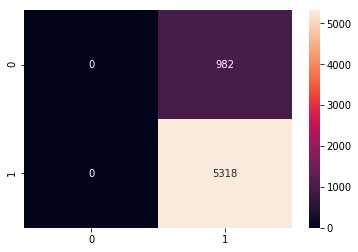

In [13]:
#model = TfidfVectorizer()
#tf_idf_matrix = model.fit_transform(X_test)
#dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(X_test):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
    
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(tfidf_sent_vectors,y_train1)
predicted_labels=[]
test_labels=[]
for k in range(1,12600,6300):
    test_labels=(y_test[k:k+6300]) 
    predicted_labels=(knn.predict(tfidf_sent_vectors_test[k:k+6300]))
    #pred = knn.predict(tfidf_sent_vectors_test)
    acc = accuracy_score(test_labels, predicted_labels, normalize=True) * float(100)
    print('\nTest accuracy for k %d is %d%%' % (optimal_k,acc))    
    
sample=confusion_matrix(test_labels,predicted_labels)
ax=sns.heatmap(sample,annot=True,fmt="d")    

<table>
    <tr>
        <th>model</th>
        <th>optimal k</th>
        <th>train error</th>
        <th>test accuracy</th>
        <th>sample size</th>
        
    </tr>
    <tr>
        <td>bow-brute</td>
        <td>1</td>
        <td>0.425</td>
        <td>79</td>
        <td>60k</td>
        
    </tr>
    <tr>
        <td>bow-kd tree</td>
        <td>1</td>
        <td>0.425</td>
        <td>79</td>
        <td>60k</td>
        
    </tr>
    <tr>
        <td>tf-idf-brute</td>
        <td>3</td>
        <td>0.373</td>
        <td>83</td>
        <td>60k</td>
        
    </tr>
    <tr>
        <td>tf-idf-kd tree</td>
        <td>3</td>
        <td>0.373</td>
        <td>83</td>
        <td>60k</td>
        
    </tr>
    <tr>
        <td>w2v-kd-tree</td>
        <td>9</td>
        <td>0.544</td>
        <td>84</td>
        <td>60k</td>
        
    </tr>
    <tr>
        <td>w2v-brute</td>
        <td>9</td>
        <td>0.544</td>
        <td>84</td>
        <td>60k</td>
        
    </tr>
    <tr>
        <td>tfidf avg w2v-brute</td>
        <td>9</td>
        <td>0.544</td>
        <td>84</td>
        <td>60k</td>
        
    </tr>
    <tr>
        <td>tfidf avg w2v-kd tree</td>
        <td>7</td>
        <td>0.544</td>
        <td>84</td>
        <td>60k</td>
        
    </tr>
</table>

        

# Observation

The best model is Tf_idf-Kd tree qith k value as "3" with minimum train error of "0.373" having test accuracy of "84%". 